In [3]:
import sys
sys.path.append('../src')
import exlib

In [4]:
import torch
import torchvision
import torch.nn.functional as F
import shap
from transformers import AutoImageProcessor, AutoModelForImageClassification

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
model = AutoModelForImageClassification.from_pretrained('google/vit-base-patch16-224')
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')

X, y = shap.datasets.imagenet50()

X = torch.from_numpy(X).permute(0,3,1,2).float()[0:2]

In [7]:
inputs = torch.tensor(processor(X)['pixel_values']).to(device)

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)


In [8]:
inputs.shape, inputs.min(), inputs.max()

(torch.Size([2, 3, 224, 224]),
 tensor(-1., device='cuda:0'),
 tensor(1., device='cuda:0'))

In [9]:
import torch.nn as nn

class WrappedBackboneModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, inputs):
        outputs = self.model(inputs, output_hidden_states=True)
        return outputs.logits

In [10]:
wrapped_model = WrappedBackboneModel(model).to(device)

In [13]:
logits = wrapped_model(inputs)
pred = torch.argmax(logits, dim=-1)
pred[0]

tensor(791, device='cuda:0')

In [14]:
import matplotlib.pyplot as plt

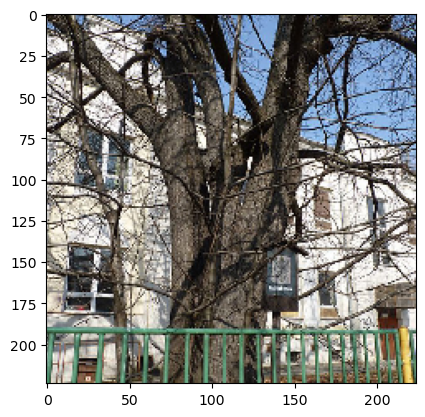

In [15]:
plt.imshow((X[0] / 255).permute(1,2,0).numpy())

In [16]:
from exlib.explainers import LimeImageCls
from exlib.explainers.common import patch_segmenter
from exlib.evaluators.attributions import NNZ


eik = {
    "segmentation_fn": patch_segmenter,
    "top_labels": 5, 
    "hide_color": 0, 
    "num_samples": 1000
}
gimk = {
    "positive_only": False
}

explainer = LimeImageCls(wrapped_model, explain_instance_kwargs=eik, 
                      get_image_and_mask_kwargs=gimk)

In [17]:
expln = explainer(inputs, pred)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
def hatch_dim_and_outline(image, mask, c=0.6): 
    black = torch.zeros(image.shape)
    dimmed_image = (c*image + (1-c)*black)
    masked_image = (mask*image + (1-mask)*dimmed_image)
    return masked_image

image torch.Size([224, 224, 3]) mask torch.Size([3, 224, 224])


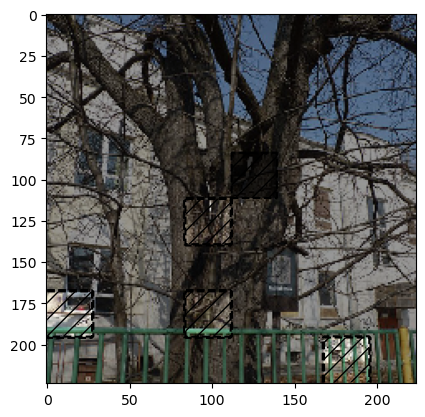

In [20]:
mask = expln.attributions[0]
image = ((inputs[0] + 1) / 2).permute(1,2,0).cpu()
print('image', image.shape, 'mask', mask.shape)
masked_image = hatch_dim_and_outline(image, mask[0].unsqueeze(-1))
plt.imshow(masked_image)
plt.contour(mask[0,:,:], 2, colors='black', linestyles='dashed')
plt.contourf(mask[0,:,:], 2, hatches=['//', None, None],
                cmap='gray', extend='neither', linestyles='--', alpha=0.01)

In [23]:
from exlib.evaluators.ins_del import InsertionCls, DeletionCls
del_evaluator = DeletionCls(wrapped_model)
with torch.no_grad():
    del_score = del_evaluator(inputs, expln.attributions)
del_score[0]

 99%|█████████▉| 223/225 [00:01<00:00, 120.38it/s]


tensor(0.0011, device='cuda:0')

 99%|█████████▉| 223/225 [00:01<00:00, 122.13it/s]


torch.Size([2, 225]) torch.Size([224, 224, 3])


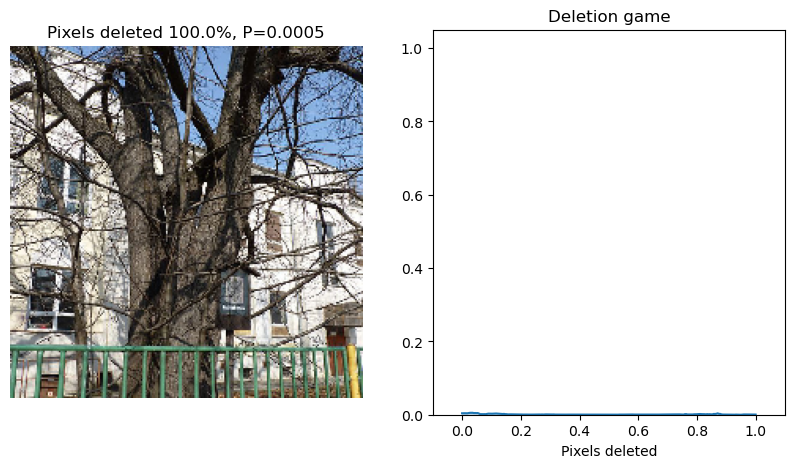

In [24]:
with torch.no_grad():
    del_output = del_evaluator(inputs, expln.attributions, return_dict=True)
del_scores = del_output['scores']
print(del_scores.shape, image.shape)
del_evaluator.plot((inputs[0] + 1) / 2, del_scores[0])

 99%|█████████▉| 223/225 [00:01<00:00, 120.17it/s]


tensor(0.0019, device='cuda:0')


 99%|█████████▉| 223/225 [00:01<00:00, 128.09it/s]


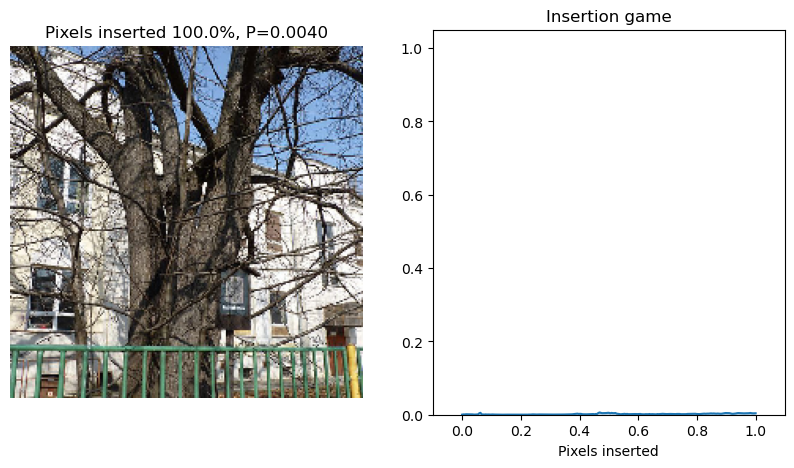

In [25]:
ins_evaluator = InsertionCls(wrapped_model)
with torch.no_grad():
    ins_score = ins_evaluator(inputs, expln.attributions)
print(ins_score[0])
with torch.no_grad():
    ins_output = ins_evaluator(inputs, expln.attributions, return_dict=True)
ins_scores = ins_output['scores']
ins_evaluator.plot((inputs[0] + 1) / 2, ins_scores[0])